# 量子アニーリングによる配送計画(実践編)

## 概要

記事「[量子アニーリングマシンによる配送計画](https://qard.is.tohoku.ac.jp/T-Wave/?p=1729)」で扱った論文では、CVRP(容量制約有りの配送計画問題)を量子アニーリングマシンと古典コンピュータを用いたハイブリッドな手法で解き、その性能を古典コンピュータと比較していました。本記事では、論文中で登場した[CVRPLIB](http://vrp.galgos.inf.puc-rio.br/index.php/en/)のデータセットについてクラスタリングはSA（シミュレーテッドアニーリング）、ルーティングは[GoogleのOR-Tools](https://developers.google.com/optimization)を利用して解いています。

## 文献情報


- 1つ目の論文
  - タイトル：A Hybrid Solution Method for the Capacitated Vehicle Routing Problem Using a Quantum Annealer

  - 著者：Sebastian Feld, Chrisoph Roch, Thomas Gabor, Christian Seidel, Florian Neukart, Isabella Galter, Wolfgang Mauerer, and Claudia Linnhoff-Popien

  - 書誌情報：https://doi.org/10.3389/fict.2019.00013

- 2つ目の論文
  - タイトル：An Approach to the Vehicle Routing Problem with Balanced Pick-up Using Ising Machines

  - 著者：Siya Bao, Masashi Tawada, Shu Tanaka, Nozomu Togawa

  - 書誌情報：https://ieeexplore.ieee.org/document/9427355

## 問題

この実践記事では、以下の2種類の手法でCVRPを解いてみました。

1. 元論文に載っていた手法
2. 容量の平均値に寄せる手法



### クラスタリング

#### Part1 元論文に載っていた手法

[論文紹介の記事](https://qard.is.tohoku.ac.jp/T-Wave/?p=1729)では、容量制約付きのクラスタリングに関する定式化を省いていたので、ここで簡単に説明します。

まずは変数についてです。

- $x_{v}^k$: $k$番目のクラスターに$v$番目の顧客が含まれるときは1を、そうでないときは0をとる二値変数
- $y_n^k$: 不等式制約を考えるための擬似変数

最適化に必要な入力データは以下のとおりです。
- $w_{v}$: 顧客の要求量を表す定数
- $D_{uv}$: 顧客どうしの距離を表す行列
- $m$: クラスターの数、$W$はクラスターの容量の最大値

続いて定式化です。

1．トラックの容量に関する不等式制約
$$ H_A = X\sum_{k=1}^m\left(1-\sum_{n=1}^Wy_n^k\right)^2 + A\sum_{k=1}^m\left(\sum_{n=1}^Wny_n^k- \sum_{v=1}^n w_{v} x_{v}^k\right)^2 $$

第一項がトラックの容量を一つに定めるone-hot制約、第二項がトラックの容量と荷物の重量の総和を等しくする制約となっています。

2．one-hot制約
$$ H_B = B\sum_{v=1}^n \left(1- \sum_{k=1}^{m}x_{v}^k\right)^2 $$

この式は、顧客が一つのクラスターにだけ含まれるようにする制約となっています。

3．距離に関するコスト関数
$$ H_C = C\sum_{k=1}^{m}\left(\sum_{(u,v)\in E}D_{uv}x_u^kx_v^k\right)$$

クラスター内の顧客どうしの距離の総和を計算しています。これが最小になるような解を求めることがCVRPのクラスタリング部分の目的です。なお、$X,A,B,C$は制約の重みを決定するための定数です。

いざ実践！実際にこの定式化を[pyqubo](https://pyqubo.readthedocs.io/en/latest/)で記述していきます。

今回解くデータは[こちら](http://vrp.galgos.inf.puc-rio.br/index.php/en/)のサイトから見ることができます。

まずは、必要なライブラリをインストールします。

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install dwave-ocean-sdk
!pip install openjij
!pip install ortools
!pip install vrplib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
from pyqubo import Array, Constraint, Placeholder

この記事では、[CVRPLIB](http://vrp.galgos.inf.puc-rio.br/index.php/en/)のCMT1インタスンスを実験の対象とします。

In [ ]:
import vrplib

instance_name = "CMT1"
path_instance = "cvrp.vrp"
path_solution = "cvrp.sol"

vrplib.download_instance(instance_name, path_instance)
vrplib.download_solution(instance_name, path_solution)

vrp_instance = vrplib.read_instance(path_instance)
vrp_solution = vrplib.read_solution(path_solution)

In [ ]:
customers = vrp_instance["node_coord"]
customers_nodepot = customers[1:]  # 0: depot
cus_num = len(customers_nodepot)

In [ ]:
# 距離行列の生成
D_uv = np.zeros((cus_num, cus_num))
for u in range(cus_num):
    for v in range(u + 1, cus_num):
        distance_uv = np.linalg.norm(customers_nodepot[u] - customers_nodepot[v])
        D_uv[u][v] = D_uv[v][u] = distance_uv

D_uv_normed = D_uv / np.max(D_uv)
print(D_uv_normed)

[[0.         0.14444578 0.22432224 ... 0.14444578 0.30830144 0.28268839]
 [0.14444578 0.         0.17863522 ... 0.28889157 0.24551063 0.16223248]
 [0.22432224 0.17863522 0.         ... 0.33235458 0.42298608 0.31874053]
 ...
 [0.14444578 0.28889157 0.33235458 ... 0.         0.41418987 0.41861108]
 [0.30830144 0.24551063 0.42298608 ... 0.41418987 0.         0.14061873]
 [0.28268839 0.16223248 0.31874053 ... 0.41861108 0.14061873 0.        ]]


In [ ]:
demands = vrp_instance["demand"][1:]  # 0: depot
print(demands)

[ 7 30 16  9 21 15 19 23 11  5 19 29 23 21 10 15  3 41  9 28  8  8 16 10
 28  7 15 14  6 19 11 12 23 26 17  6  9 15 14  7 27 13 11 16 10  5 25 17
 18 10]


In [ ]:
# 車両の設定
car_num = 5  # 車の台数
capa = vrp_instance["capacity"]  # トラックの容量

次にpyquboに数式を書いていきます。

In [ ]:
def make_pyqubo_model1(car_num, cus_num, capa, D_uv, demands):
    x = Array.create("x", shape=(cus_num, car_num), vartype="BINARY")
    y = Array.create("y", shape=(capa, car_num), vartype="BINARY")

    H_A_1 = np.sum(
        [
            (1 - np.sum([y[i - 1, k] for i in range(1, capa + 1)])) ** 2
            for k in range(car_num)
        ]
    )
    H_A_2 = np.sum(
        [
            (
                np.sum([i * y[i - 1, k] for i in range(1, capa + 1)])
                - np.sum([demands[v] * x[v, k] for v in range(cus_num)])
            )
            ** 2
            for k in range(car_num)
        ]
    )
    H_B = np.sum(
        [(1 - np.sum([x[v, k] for k in range(car_num)])) ** 2 for v in range(cus_num)]
    )
    H_C = np.sum(
        [
            np.sum(
                [
                    D_uv[u, v] * x[u, k] * x[v, k]
                    for u, v in itertools.combinations(range(cus_num), 2)
                ]
            )
            for k in range(car_num)
        ]
    )

    H = Placeholder("X") * Constraint(H_A_1, "H_A_1") + Placeholder("A") * Constraint(
        H_A_2, "H_A_2"
    )
    H = H + Placeholder("B") * Constraint(H_B, "H_B") + Placeholder("C") * H_C

    return H.compile()

In [ ]:
model1 = make_pyqubo_model1(car_num, cus_num, capa, D_uv, demands)

In [ ]:
feed_dict1 = dict(X=2500.0, A=50.0, B=2500.0, C=1.0)  # いろいろ係数を調整してみてください
bqm1 = model1.to_bqm(feed_dict=feed_dict1)
print("num_variables:", bqm1.num_variables)

num_variables: 1050


In [ ]:
# SAの場合
from neal import SimulatedAnnealingSampler

sampler = SimulatedAnnealingSampler()

# D-Waveマシンの場合
# from dwave.system import DWaveSampler, EmbeddingComposite
# sampler_config = dict(solver="Advantage_system6.2", token="YOUR_TOKEN")
# sampler = EmbeddingComposite(DWaveSampler(**sampler_config))

In [ ]:
sampler_params1 = dict(num_reads=10, num_sweeps=10000)
sampleset1 = sampler.sample(bqm1, **sampler_params1).aggregate()
sampleset1.to_pandas_dataframe().head()

,x[0][0],x[0][1],x[0][2],x[0][3],x[0][4],x[10][0],x[10][1],x[10][2],x[10][3],x[10][4],...,y[99][2],y[99][3],y[99][4],y[9][0],y[9][1],y[9][2],y[9][3],y[9][4],energy,num_occurrences
0,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,124523.128859,1
1,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,175790.620470,1
2,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,191027.912279,1
3,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,145609.056330,1
4,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,144379.351831,1


one-hot制約や容量制約を満たしているか確認しましょう。Falseが表示される場合はその制約は満たされていないということを示しています。

In [ ]:
# 制約を満たしているかどうかを確認する
decoded_samples1 = model1.decode_sampleset(sampleset1, feed_dict1)

for sample in decoded_samples1:
    print(sample.energy)
    print(sample.constraints(only_broken=True))

124523.12880269997
{'H_A_2': (False, 75.0), 'H_B': (False, 16.0), 'H_A_1': (False, 27.0)}
144379.35184135474
{'H_A_2': (False, 47.0), 'H_B': (False, 25.0), 'H_A_1': (False, 25.0)}
145609.0562772788
{'H_A_2': (False, 64.0), 'H_B': (False, 28.0), 'H_A_1': (False, 22.0)}
151658.67309271824
{'H_A_2': (False, 33.0), 'H_B': (False, 26.0), 'H_A_1': (False, 27.0)}
173256.15261312574
{'H_A_2': (False, 51.0), 'H_B': (False, 35.0), 'H_A_1': (False, 25.0)}
173511.7737898957
{'H_A_2': (False, 69.0), 'H_B': (False, 33.0), 'H_A_1': (False, 27.0)}
175790.62046944257
{'H_A_2': (False, 61.0), 'H_B': (False, 31.0), 'H_A_1': (False, 30.0)}
191027.9123360645
{'H_A_2': (False, 74.0), 'H_B': (False, 30.0), 'H_A_1': (False, 37.0)}
194297.09123693034
{'H_A_2': (False, 46.0), 'H_B': (False, 30.0), 'H_A_1': (False, 39.0)}
216092.85363079607
{'H_A_2': (False, 80.0), 'H_B': (False, 45.0), 'H_A_1': (False, 30.0)}


何回か制約項の係数を変えて実行してみてください。ある真実に気づくはずです。

そう。すべての制約項が0になるように係数を調整することが難しいということに！

（かなりの時間試しましたが、筆者は二つの制約項を0にすることしかできませんでした...）

考えられる原因としては以下のことが挙げられます。

1. 3つの係数をバランスよく調整する必要がある。

2. 顧客の要求量や顧客同士の距離に関してオーダーが異なる。

3. そもそも不等式制約をそのまま解くことは難しい。

この段階で、論文に載っていた定式化で解くことは難しいということになり、新たな手法を取ることになりました。

#### Part2 容量の平均値に寄せる手法

次に用いた手法が2つ目の論文に載っている定式化です。

Part1と異なるのは容量制約に関する部分です。具体的には以下のようになります。

重みに関する制約
$$ H_D = D\sum_{k=1}^m\left(H_{D'} - \sum_{v=1}^n w_v x_v^k \right)^2$$

$$ H_{D'} = \frac{1}{m}\sum_{k=1}^m\left(\sum_{v=1}^n w_v x_v^k \right) $$

これは、すべての荷物の総和を車の台数で割ったもの（車に割り当てるべき容量の平均値）に近づける制約になっています。（この制約は0にはならないことに注意が必要）

この$H_D$を先ほどの$H_A$と置き換える形で解いていきます。

In [ ]:
# 顧客の要求量に関して正規化する
demands_normed = demands / capa
print(demands_normed)

[0.04375 0.1875  0.1     0.05625 0.13125 0.09375 0.11875 0.14375 0.06875
 0.03125 0.11875 0.18125 0.14375 0.13125 0.0625  0.09375 0.01875 0.25625
 0.05625 0.175   0.05    0.05    0.1     0.0625  0.175   0.04375 0.09375
 0.0875  0.0375  0.11875 0.06875 0.075   0.14375 0.1625  0.10625 0.0375
 0.05625 0.09375 0.0875  0.04375 0.16875 0.08125 0.06875 0.1     0.0625
 0.03125 0.15625 0.10625 0.1125  0.0625 ]


In [ ]:
def make_pyqubo_model2(car_num, cus_num, capa, D_uv_normed, demands):
    x = Array.create("x", shape=(cus_num, car_num), vartype="BINARY")

    H_B = np.sum(
        [(1 - np.sum([x[v, k] for k in range(car_num)])) ** 2 for v in range(cus_num)]
    )  # one-hot
    H_C = np.sum(
        [
            np.sum(
                [
                    D_uv_normed[u, v] * x[u, k] * x[v, k]
                    for u, v in itertools.combinations(range(cus_num), 2)
                ]
            )
            for k in range(car_num)
        ]
    )  # 距離
    H_D = np.sum(
        [
            (
                np.sum(demands) / car_num
                - np.sum([demands[v] * x[v, k] for v in range(cus_num)])
            )
            ** 2
            for k in range(car_num)
        ]
    )  # balance

    H = (
        Placeholder("B") * Constraint(H_B, "H_B")
        + Placeholder("C") * H_C
        + Placeholder("D") * H_D
    )
    return H.compile()

In [ ]:
model2 = make_pyqubo_model2(car_num, cus_num, capa, D_uv_normed, demands_normed)

In [ ]:
feed_dict2 = dict(B=3, C=1, D=100)
bqm2 = model2.to_bqm(feed_dict=feed_dict2)
print("num_variables:", bqm2.num_variables)

num_variables: 250


上のコードの実行結果から補助変数がないため、変数の総数が一つ目の手法と比較して少なくなっていることが確認できます。

50のデータについてはB=3,C=1,D=100にすると容量制約を満たしたよい結果を得ることができました。

In [ ]:
# SAの場合
sampler = SimulatedAnnealingSampler()

# D-Waveマシンの場合 サイズ50だと大きいため解けない
# from dwave.system import DWaveSampler, EmbeddingComposite
# sampler_config = dict(solver="Advantage_system6.2", token="")
# sampler = EmbeddingComposite(DWaveSampler(**sampler_config))

In [ ]:
sampler_params2 = dict(num_reads=10, num_sweeps=10000)
sampleset2 = sampler.sample(bqm2, **sampler_params2).aggregate()
sampleset1.to_pandas_dataframe().head()

,x[0][0],x[0][1],x[0][2],x[0][3],x[0][4],x[10][0],x[10][1],x[10][2],x[10][3],x[10][4],...,y[99][2],y[99][3],y[99][4],y[9][0],y[9][1],y[9][2],y[9][3],y[9][4],energy,num_occurrences
0,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,124523.128859,1
1,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,144379.351831,1
2,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,145609.056330,1
3,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,151658.673178,1
4,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,173256.152676,1


In [ ]:
decoded_samples2 = model2.decode_sampleset(sampleset2, feed_dict2)
for sample in decoded_samples2:
    print(sample.energy)
    print(sample.constraints(only_broken=True))

42.75833681104177
{}
42.75833681104177
{}
42.75833681104177
{}
43.31782178360663
{}
44.5085063285926
{}
45.84433192465008
{}
46.07861765315647
{}
46.21355565055228
{}
46.919144259469476
{}
47.258181302545495
{}


筆者が実行した際は一番良いものでエネルギーが約42.8という結果が得られました。

In [ ]:
def sample_to_assignment(sample, car_num, cus_num):
    assignment = []
    for m in range(cus_num):
        for n in range(car_num):
            if sample[f"x[{m}][{n}]"] == 1:
                assignment.append((m, n))
    return assignment

In [ ]:
sample2 = decoded_samples2[0]
assignment2 = sample_to_assignment(sample2.sample, car_num, cus_num)
print(assignment2)

[(0, 4), (1, 4), (2, 4), (3, 0), (4, 3), (5, 2), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 3), (12, 0), (13, 2), (14, 3), (15, 1), (16, 3), (17, 0), (18, 0), (19, 4), (20, 1), (21, 4), (22, 2), (23, 2), (24, 0), (25, 2), (26, 2), (27, 4), (28, 4), (29, 1), (30, 4), (31, 4), (32, 3), (33, 1), (34, 4), (35, 4), (36, 3), (37, 1), (38, 1), (39, 0), (40, 0), (41, 0), (42, 2), (43, 3), (44, 3), (45, 3), (46, 3), (47, 2), (48, 1), (49, 1)]


In [ ]:
# 顧客がどのクラスターに属するかを示すリストを作成
belonged_cluster = [j for _, j in assignment2]
print(belonged_cluster)

[4, 4, 4, 0, 3, 2, 2, 2, 1, 1, 1, 3, 0, 2, 3, 1, 3, 0, 0, 4, 1, 4, 2, 2, 0, 2, 2, 4, 4, 1, 4, 4, 3, 1, 4, 4, 3, 1, 1, 0, 0, 0, 2, 3, 3, 3, 3, 2, 1, 1]


容量が指定値を超えていないかを次のコードで確認しましょう。

In [ ]:
def weight_check(belonged_cluster, demands, capa):
    weights = [0] * len(set(belonged_cluster))
    for i, cluster_i in enumerate(belonged_cluster):
        weights[cluster_i] += int(demands[i])

    for i, weight_i in enumerate(weights):
        if weight_i > capa:
            print(f"キャパオーバーです。(超過:{weight_i - capa})")
    print("容量制約を満たしています。")


weight_check(belonged_cluster, demands, capa)

容量制約を満たしています。


容量制約が満たされていることが確認出来たら、実際にクラスタリングされた結果を描画してみましょう。

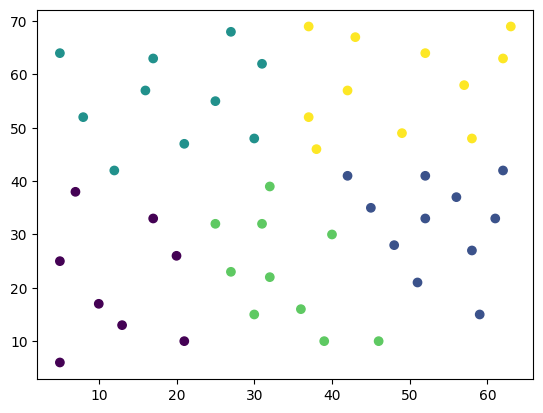

In [ ]:
# クラスタリングの結果を出力
plt.scatter(customers_nodepot[:, 0], customers_nodepot[:, 1], c=belonged_cluster)
plt.show()

記事と同じパラメーターで実行した場合、5つにきれいに色分けされた結果が得られると思います。

かなりよいクラスタリングの結果を得ることができました。

### ルーティング

続いてこのデータをもとにルーティングを実行していきます。

元論文では、ルーティングを量子アニーリングマシンを利用して解いていましたが、今回は[GoogleのOR-Tools](https://developers.google.com/optimization)を利用して解いています。

In [ ]:
# depotが入っている状態での顧客番号のリストを作成
clusters = [[0] for i in range(car_num)]  # depotの番号は初めから追加しておく
for i in range(cus_num):
    clusters[belonged_cluster[i]].append(i + 1)  # depotが含まれている状態に戻すために数字を+1する
print(clusters)

[[0, 4, 13, 18, 19, 25, 40, 41, 42], [0, 9, 10, 11, 16, 21, 30, 34, 38, 39, 49, 50], [0, 6, 7, 8, 14, 23, 24, 26, 27, 43, 48], [0, 5, 12, 15, 17, 33, 37, 44, 45, 46, 47], [0, 1, 2, 3, 20, 22, 28, 29, 31, 32, 35, 36]]


In [ ]:
# 同一クラスターにおける顧客どうしの距離を計算する
distance_matrices = []
for i in range(car_num):
    cluster_size = len(clusters[i])
    distance_matrix = np.zeros((cluster_size, cluster_size))
    for j in range(cluster_size):
        for k in range(j + 1, cluster_size):
            distance_jk = np.linalg.norm(
                customers[clusters[i][j]] - customers[clusters[i][k]]
            )
            distance_matrix[j][k] = distance_matrix[k][j] = distance_jk

    distance_matrices.append(distance_matrix.tolist())

In [ ]:
# ortoolsを利用して巡回セールスマン問題を解く
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def print_solution(manager, routing, solution, j):
    index = routing.Start(0)
    plan_output = f"Route for vehicle {j}:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += " {} ->".format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += " {}\n".format(manager.IndexToNode(index))
    plan_output += "Route distance: {}miles\n".format(route_distance)
    print(plan_output)
    return route_distance


def get_routes(solution, routing, manager):
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

In [ ]:
solutions = []
route_dis = []

for j in range(len(clusters)):
    distance_matrix = distance_matrices[j]

    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node])  # ortoolsの仕様でintを返す

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    solution = routing.SolveWithParameters(search_parameters)

    if solution is None:
        print("No solution found !")
        continue

    # 解を表示する
    route_dis.append(print_solution(manager, routing, solution, j + 1))

    routes = get_routes(solution, routing, manager)
    for i, route in enumerate(routes):
        solutions.append(route)

Route for vehicle 1:
 0 -> 3 -> 5 -> 2 -> 7 -> 6 -> 4 -> 8 -> 1 -> 0
Route distance: 110miles

Route for vehicle 2:
 0 -> 3 -> 4 -> 11 -> 5 -> 7 -> 6 -> 9 -> 2 -> 10 -> 1 -> 8 -> 0
Route distance: 106miles

Route for vehicle 3:
 0 -> 8 -> 10 -> 3 -> 7 -> 2 -> 5 -> 9 -> 6 -> 4 -> 1 -> 0
Route distance: 105miles

Route for vehicle 4:
 0 -> 9 -> 2 -> 1 -> 5 -> 8 -> 3 -> 7 -> 6 -> 4 -> 10 -> 0
Route distance: 87miles

Route for vehicle 5:
 0 -> 9 -> 2 -> 7 -> 4 -> 10 -> 11 -> 3 -> 6 -> 8 -> 5 -> 1 -> 0
Route distance: 113miles



ルーティングの答えを得ることができたので、実際にどんなルートになったのかを描画してみます。

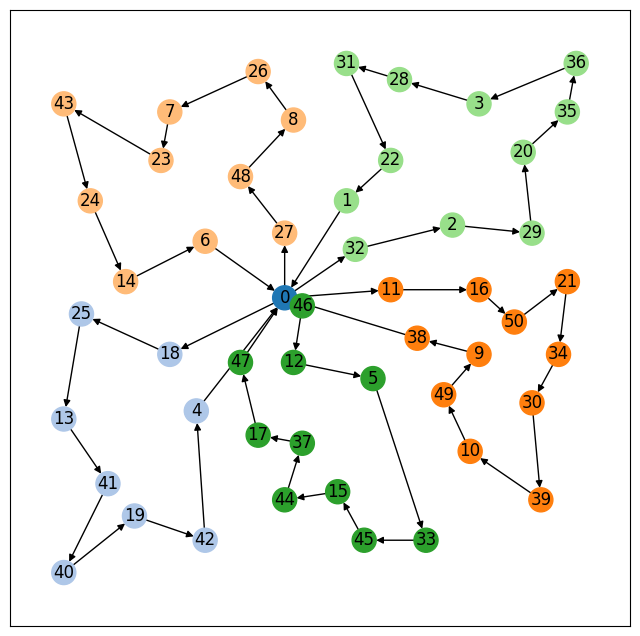

In [ ]:
import networkx as nx


# 解を視覚的に描画する関数
def print_routes(car_num, solutions, belonged_cluster, customers):
    # 元のデータ番号での呼び出し
    solutions2 = [[] for i in range(car_num)]
    for i in range(len(solutions)):
        for j in range(len(solutions[i])):
            solutions2[i].append(clusters[i][solutions[i][j]])

    # 各顧客について色を指定する
    cm = plt.get_cmap("tab20")
    node_list = [(0, {"color": cm(0)})]
    for i in range(len(belonged_cluster)):
        node_list.append((i + 1, {"color": cm(belonged_cluster[i] + 1)}))

    # depotおよび顧客の番号と位置に関する辞書を作成
    pos = {}
    for i in range(len(customers)):
        pos[i] = (customers[i][0], customers[i][1])

    # ルーティングで得られた解をもとに実際に通る辺のリストを作成
    edge_list = []
    for i in range(len(solutions2)):
        for j in range(len(solutions2[i]) - 1):
            edge_list.append((solutions2[i][j], solutions2[i][j + 1]))

    g = nx.DiGraph()
    g.add_nodes_from(node_list)
    g.add_edges_from(edge_list)

    node_color = [node["color"] for node in g.nodes.values()]
    plt.figure(figsize=(8, 8))  # 見やすいようにサイズを変更してください
    nx.draw_networkx(g, pos, with_labels=True, node_color=node_color)
    plt.show()


print_routes(car_num, solutions, belonged_cluster, customers)

OR-Toolsの○○mileという表記は小数点以下が切り捨てられているので、正しい距離を計算します。

In [ ]:
# 各ルートの距離を計算する
distance_sum = []
for i in range(len(solutions)):
    sum = 0
    for j in range(len(solutions[i]) - 1):
        sum += distance_matrices[i][solutions[i][j]][solutions[i][j + 1]]
    distance_sum.append(sum)

for i in range(len(distance_sum)):
    print(f"{i+1}番目のルートの距離の総和: {distance_sum[i]}")
print(np.sum(distance_sum))

1番目のルートの距離の総和: 113.02515612536826
2番目のルートの距離の総和: 110.42427768703959
3番目のルートの距離の総和: 108.17151038656631
4番目のルートの距離の総和: 90.23091471949962
5番目のルートの距離の総和: 115.51879142816513
537.370650346639


In [ ]:
bks = vrp_solution["cost"]  # 厳密解
ans = np.sum(distance_sum)
print((ans - bks) / bks * 100, "%")

2.4322117429178913 %


厳密解(BKS)との偏差は+約2.4%という結果になりました。

元論文のハイブリッドな手法では、厳密解との偏差が5.98%であったので、かなり良い結果を得られたといえるでしょう！

しかし、よりサイズの大きいデータセットを解いてみようとすると、容量制約を満たしてもクラスタリングがうまくいかず、厳密解の偏差もハイブリッドの手法より悪い結果となりました。（詳細は省きます。）

## まとめ

今回実際に論文で扱われていたCMT1というデータセットをクラスタリングはSA、ルーティングはGoogleのOR-Toolsを使って解きました。

CMT1に対しては厳密解を得ることはできませんでしたが、厳密解にかなり近い解を得ることができました。しかし、サイズの大きいデータセットに対しては制約を満たす良い解を得ることが難しかったです。

今後の展望としては、SAによるクラスタリング後にクラスタリングを改善するアルゴリズムを導入するといったことが考えられます。

## あとがき

今回実際に論文の問題を解くにあたっていくつか壁に当たりました。

1.  論文通りにアルゴリズムを実装するも容量がきつきつで、荷物の入れ替わりが起こらずクラスタリングがうまくいかない。

2. 自分で量子アニーリングマシンを利用して解こうとするも制約を満たしてくれない。

3. 論文の定式化通りの実装をしてもクラスタリングがうまくいかない。

といった感じです。何回か心が折れましたが、実際にかなり良い結果が得られ、それを描画した時には達成感がありました。

今後も同様に再現実験を通してコーディングの技術を磨いていきたいです。

また、今回2本目として紹介した論文や、容量制約で用いた不等式制約に関する論文を読んで、CVRPという問題に対して知識を増やしていきたいと思いました。実社会に即した問題を解けるように頑張りたいと思います。